# 0.1.6: Comparing observation densities of GBIF and sPlot after matching with TRY


## Imports and config


In [1]:
from src.conf.conf import get_config

cfg = get_config()

To compare the observation densities after matching with TRY, we can simply explore the `count` layer of the GBIF and sPlot versions of a single trait.


In [13]:
from src.utils.dataset_utils import read_trait_map

TRAIT_ID = "X14"  # Leaf N (by mass)
splot = read_trait_map(TRAIT_ID, "splot", band=6)
gbif = read_trait_map(TRAIT_ID, "gbif", band=6)
comb = splot.combine_first(gbif)

In [14]:
# Get number of non-null values in splot xr.datarray
splot_non_null = splot.count()
gbif_non_null = gbif.count()
comb_non_null = comb.count()

In [16]:
print(f"sPlot matched pixels: {splot_non_null.values.item()}")
print(f"GBIF matched pixels: {gbif_non_null.values.item()}")
print(f"Combined matched pixels: {comb_non_null.item()}")

sPlot matched pixels: 430213
GBIF matched pixels: 2392987
Combined matched pixels: 2646876


Plot both sPlot and GBIF count layers side by side.


In [148]:
REDUCE_FACTOR: int = 55
splot_coarsened = splot.coarsen(x=REDUCE_FACTOR, y=REDUCE_FACTOR, boundary="trim").sum()
gbif_coarsened = gbif.coarsen(x=REDUCE_FACTOR, y=REDUCE_FACTOR, boundary="trim").sum()

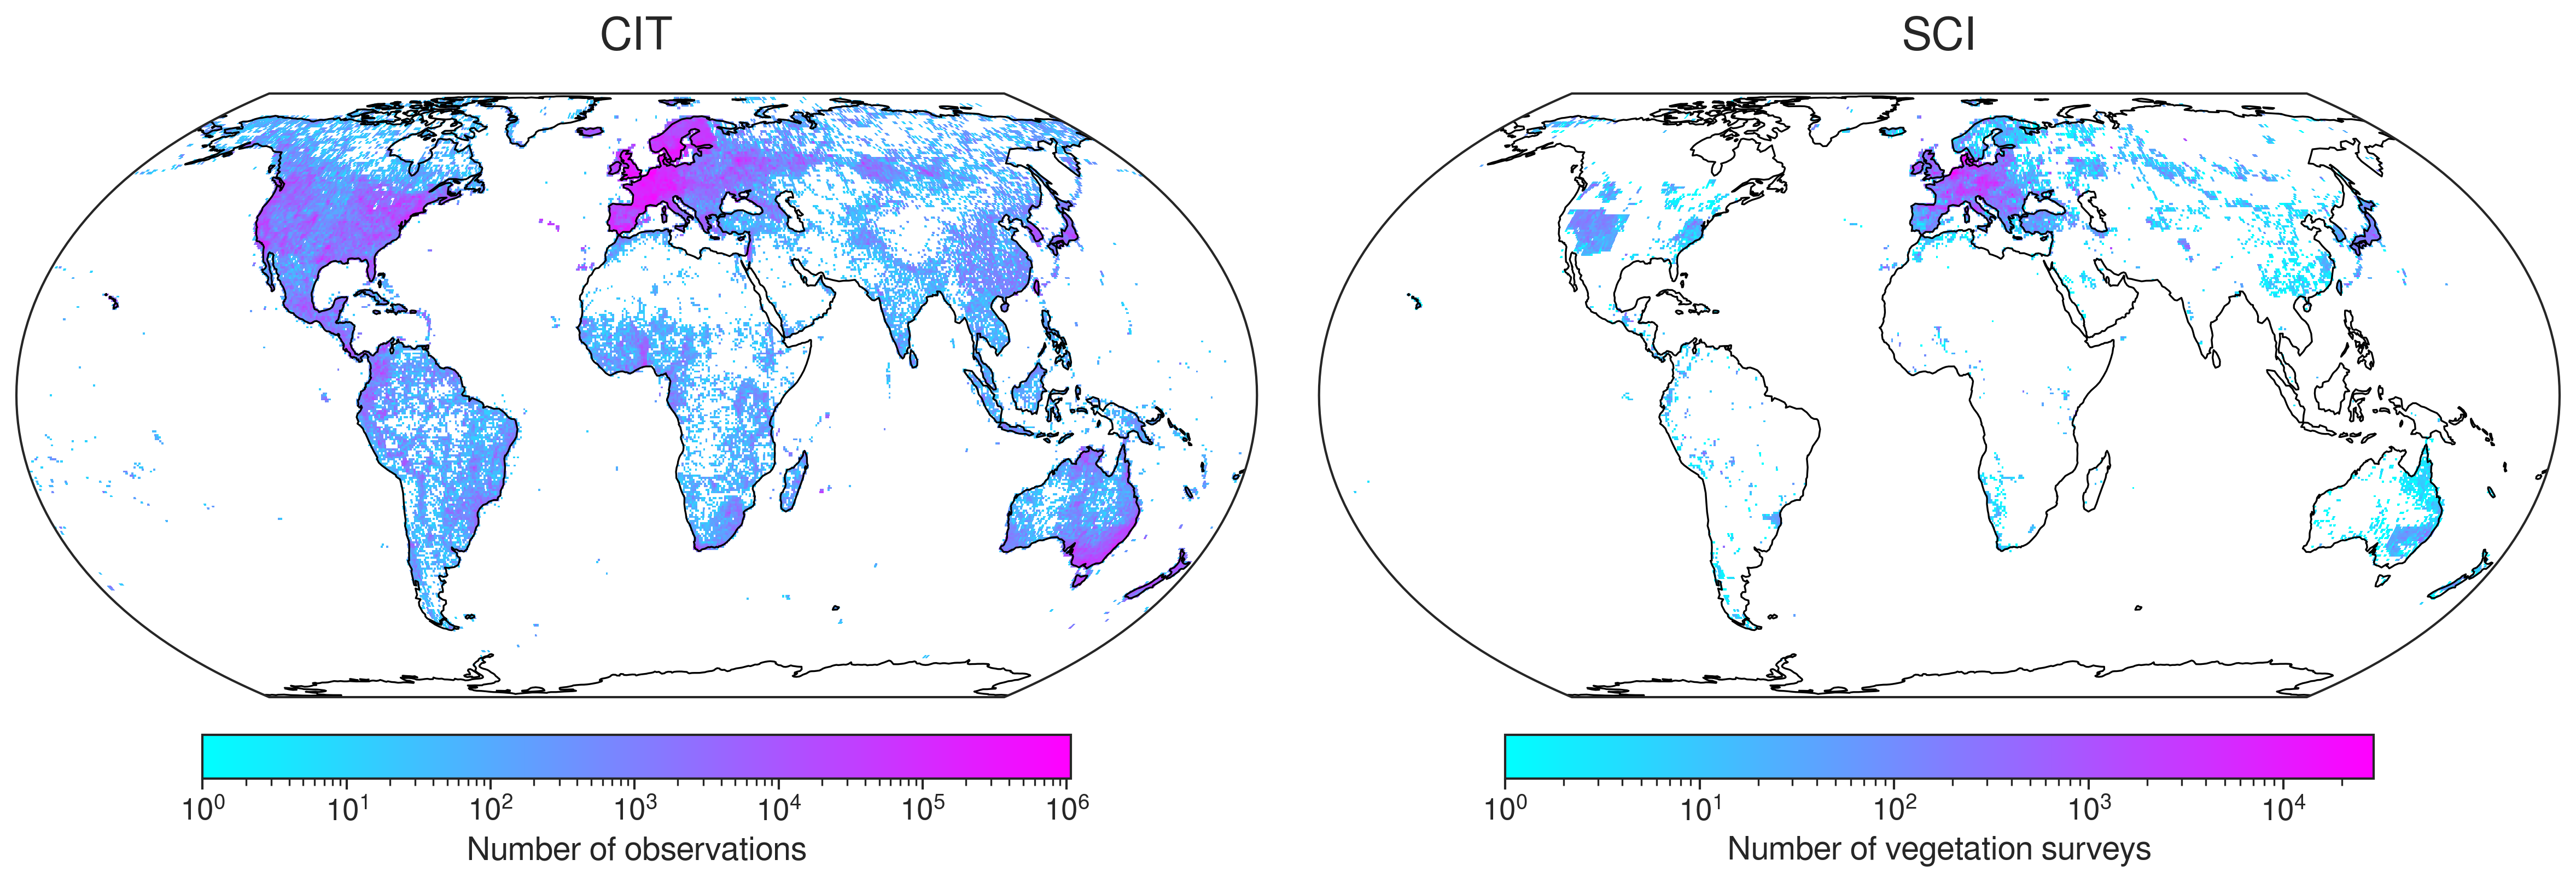

In [156]:
from matplotlib import gridspec
from matplotlib.colors import LogNorm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import seaborn as sns

from src.utils.plotting_utils import set_font

SAVE = True

set_font("FreeSans")

sns.set_theme(context="paper", style="ticks", font="FreeSans", font_scale=1.5)
fig = plt.figure(figsize=(20, 10), dpi=300)
gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 1], wspace=0.05)

ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.EqualEarth())
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.EqualEarth())

for ax, data, title in zip(
    [ax0, ax1], [gbif_coarsened, splot_coarsened], ["CIT", "SCI"]
):
    ax.set_title(title, fontsize=20, y=1.05)
    ax.coastlines()
    xx, yy = data.x, data.y
    data.values[data.values == 0] = np.nan
    im = ax.pcolormesh(
        xx,
        yy,
        data.values,
        shading="auto",
        rasterized=True,
        # origin="upper",
        norm=LogNorm(vmin=1), #, vmax=splot_coarsened.max()),
        # extent=data.extent,
        cmap="cool",
        transform=ccrs.epsg("6933"),
    )
    obs_type = "observations" if title == "CIT" else "vegetation surveys"
    extend = "max" if title == "CIT" else None
    cbar = plt.colorbar(
        im,
        ax=ax,
        orientation="horizontal",
        shrink=0.7,
        pad=0.03,
        label=f"Number of {obs_type}",
        # extend=extend
    )

if SAVE:
    plt.savefig("results/figures/obs_density.png", bbox_inches="tight", dpi=300)